在机器学习和第一性原理计算的原子/离子relaxation中都涉及到了优化问题，对于机器学习，目标是寻找一组参数使得模型能够完成给定的目标，如给出原子坐标和元素种类后，能得到体系的能量和原子受力。对于原子/离子的relaxation问题，则是优化给定体系中原子/例子的坐标，使得每个原子/离子的受力最小（此时体系能量最低）。

前面这两个例子中都用到了梯度下降法，这篇文章将围绕梯度下降法讲述一些基础概念，这些概念对于机器学习，原子/离子relaxation都有帮助。  

首先看一个最简单的例子：二次函数优化，给定函数$y = x^2$，求函数最小值。这个例子比较简单，可以令函数的导数为0得到答案。但对于复杂的优化问题，我们没有函数的公式，无法求解析解，只能用数值计算求数值解，梯度下降法就是一种常用的数值求解方法。

对于$y = x^2$，可以得到每一点的梯度（导数）公式为：$y = 2x$，然后随便猜一个初值，比如假设x=3这个点y值最小。然后计算得到x=3处的梯度grad = 2 \* 3 = 6，接下来用下面的公式来更新x的位置：
$$x_n = x_{n-1} - lr * grad$$
`lr`可以对应机器学习中的学习率(learning rate),当`lr`设置得到并且n足够大时，我们就能找到$y = x^2$的最小值。下面我们来实现一下这个算法：

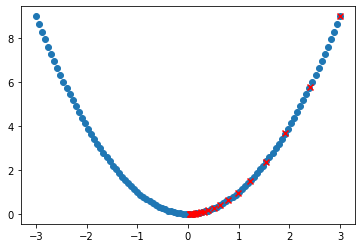

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def func(x):
    return x * x
def grad(x):
    return 2 * x

x_guess = 3
lr = 0.1
threshold = 0.01

def optimization(x_guess, lr, threshold):
    x = x_guess
    diff = 99999
    y = func(x_guess)

    xs = [x_guess]
    ys = [y]
    max_iter = 1000
    while diff > threshold and max_iter > 0:
        x = x - lr * grad(x)
        xs.append(x)
        max_iter -= 1
        if len(xs) > 1:
            # 当当前的x值与上一步x值的距离小于一定值时，认为已经找到了最小值
            diff = abs(xs[-1] - xs[-2])

        # 以下代码仅用于画图
        ys.append(func(x))
    return xs, ys
    
xs, ys = optimization(x_guess, lr, threshold)
# 以下代码仅用于迭代过程可视化
x_arr = np.linspace(-3, 3, 100)
y_arr = [func(x) for x in x_arr]
plt.scatter(x_arr, y_arr)
plt.scatter(xs, ys, c='r',  marker='x')

In [26]:
print("iteration number: {}".format(len(xs)))
ys[-5:]

iteration number: 21


[0.007130534626283792,
 0.004563542160821628,
 0.0029206669829258416,
 0.0018692268690725384,
 0.0011963051962064245]

上面的代码中使用了$\left|x_n - x_{n-1}\right| < threshold$来作为迭代终止的条件(max_iter=1000作为辅助判断条件，防止死循环)，可以看到一共迭代了21步，最后5步的值已经非常接近0了，几乎就是正确答案。神经网络训练中最常用的SGD算法，VASP中IBRION=3(steepest descent algorithm, POTIM可以认为是lr)算法归根结底都是上面的梯度下降法。

在神经网络的训练中，当loss不再降低时，认为迭代次数已经足够，模型训练完成；在原子/离子relaxation问题中，当当前步和上一步中energy或者原子受力force差值的绝对值小于一定值时，认为迭代次数已经足够，结构优化完成。

## 优化过程中的几个重要问题

### 初猜值问题

数值优化方法（梯度下降法是其中一种方法）都需要一个初始猜测值，并且计算的结果和迭代的次数都依赖初猜值。在$y = x^2$这个问题中，x_guess = 3需要迭代21次，而x_guess = 1只需要迭代16次，好的初始猜测值能明显加速模型收敛。

在神经网络中，模型优化对于初始猜测值不算太敏感，一般使用随机初始化即可（框架可自动完成）。而第一性原理计算对初始猜测值就比较敏感了，细心的同学应该能发现，vasp做结构优化，第一个离子步中电子步的迭代一般都需要几十步，之后电子步迭代次数会明显降低。这就是因为第一个离子步中电子结构初始猜测比较差，需要较多步数才能收敛（注意：电子步的优化方法不是梯度下降，数值优化方法都存在初猜的问题），后面每一个离子步中的电子结构初猜，都使用前一个离子步中已经收敛的电子结构，因此只需少量迭代就能收敛。Guassian的一大优势就是电子初猜很不错，导致需要的迭代次数少于其它同类型软件。

对于原子/离子relaxation同样存在这个问题，不借助工具随手画一个分子结构，将会需要很多离子步才能得到最终构型。但如果先用分子力学MM优化一下构型，作为一个好的初始猜测，再跑第一性原理构型优化，所需的离子步将会显著减少。

### 局部最小值 vs 全局最小值
数值优化方法（包括梯度下降法）一般只能找到局部最小值点，而很难或者几乎不可能找到全局最小值点，这导致不同的初猜值甚至可以得到完全不同的结果。
考虑函数:
$$y = x^4+x^3-7x^2-x+6$$
其图像大致如下：

![](figs/optimization-1.png)

使用x_guess=-3.5和x_guess=0.5将会得到完全不同的结果，并且前者找到的是全局最小值，而后者只能找到局部最小值。

对于神经网络来说，从实践来看，随机给一个初始猜测，最后训练的模型都差不多，没有显著区别。一种解释认为神经网络参数量太大（上亿参数），里面的极小值点效果都差不多，不一定非要找到全局最小值。

对于第一性原理结构优化来说，不同的初始构型将会得到不同的结果。简单的问题如下图中的乙醇，O上的H原子可以旋转180°作为另一个初猜来做结构优化，最终可以得到两种不同构型的乙醇分子，并且两种结构的energy不一样。

![](figs/optimization-2.png)

复杂的问题例如表面催化反应，一般认为反应发生在缺陷处，计算时首先要构建不同的缺陷位点，然后找到表面能最低的那个构型再去计算化学反应。但缺陷位点构型不计其数，基本不可能找到最稳定的构型，只能靠人的经验判断，加上一些简化和假设来做计算。

### lr值设置
lr全称learning rate，是个经验性很强的参数。

考虑函数$y = \left|0.01*x\right|$，它的导数$y^{\prime} = 0.01$非常小，如果初猜x_guess=10，那需要迭代1000次才能找到正确结果，增大learning rate能加速收敛。

当learning rate过大时，比如设置为0.9，此时跑$y = \left|x\right|$的例子，就会发现迭代进入死循环，数值求解的结果会在正确结果附近反复震荡，永不收敛。

In [ ]:
def func(x):
    if x > 0: return x
    else: return -x
def grad(x):
    if x > 0: return 1
    else: return -1
lr = 0.9

![](figs/optimization-3.png)

在神经网络的训练中，对于lr设置有大量技巧，一般在训练开始时需要warm-up,即把learning rate从0缓慢增加到指定值，然后在训练过程中逐渐减小learning rate帮助模型收敛。把learning rate的值在整个训练过程中的变化画出来大概是这样子：  
![](figs/optimization-4.png)  
设lr=0.1,在训练开始的0-3000步，lr缓慢增长到0.1，然后采用指数(exp)或者sin下降法不断降低lr值，直到训练结束。Deepmd的模型训练就采用了exp下降法，不过没有实现warm-up步骤。  
另外一种值得一提的lr调节方法是余弦退火法，在训练过程中不断增大lr又再次降低，在一定程度上可以帮助模型跳出局部最小值区域，找到更好的极小值点：  
![](figs/optimization-5.png)

总结一下，在神经网络模型训练初期，此时的初猜离真正的结果很远，需要较大的lr值来加速收敛（减小迭代次数），当模型接近真正的结果时，需要降低lr来减少震荡，帮助找到真正的结果。

在VAPS的结构优化中，可以设置`IBRION=3`来启用梯度下降法，然后设置`POTIM`值来调节lr（在vasp中也称为步长），但`POTIM`是固定的，不能逐渐降低。官方文档推荐在构型比较糟糕的情况下，刚开始可以用梯度下降法快速迭代，之后需要换成`IBRION=1`准牛顿法（收敛速度最快）或者`IBRION=2`共轭梯度法（通用性最强）来找到精确解。  
实际上，梯度下降法是一种收敛速度比较慢的算法，牛顿迭代法/准牛顿迭代法收敛速度远快于梯度下降法，但这两种方法代价很大，特别是牛顿迭代法需要求出体系的Hessian矩阵，对于结构优化只能退而求其次使用准牛顿法，而神经网络模型参数量经常几千万上亿，只能使用梯度下降法来优化。